In [3]:
import numpy as np
from scipy.stats import uniform_direction
import matplotlib.pyplot as plt
import ot
import cvxpy as cp
import time
import os

In [4]:
class generative_model:

    def __init__(self, dimension, radius, covariate_samples, dependent_samples):

        self.dimension = dimension
        self.radius = radius
        self.covariate_samples = covariate_samples
        self.dependent_samples = dependent_samples

        self.sample_size, _ = np.shape(covariate_samples.T)
        self.NN_parameter = int(np.ceil(self.sample_size ** (self.dimension / (2 * self.dimension - 1))))


    #Main generative algorithm
    def generative_algorithm(self, iteration, unit_sample_size, N_particles, step_size, reg_parameter):
        
        unit_vector_samples, projected_NN_samples = self.NN_projection(unit_sample_size)

        flow_vector = self.initialize_vector(N_particles)

        for iter in range (iteration):
            
            iteration_vector = np.zeros((self.dimension, N_particles))
            
            for particle_index in range(N_particles):
                projected_particle_samples = self.projected_particle_samples(flow_vector, unit_vector_samples, unit_sample_size, N_particles)
                particle_drift = self.particle_drift(flow_vector[:, particle_index], unit_vector_samples, projected_NN_samples, projected_particle_samples, unit_sample_size, N_particles)
                iteration_vector[:, particle_index] = step_size * particle_drift.reshape((-1)) + np.sqrt(2 * reg_parameter * step_size) * np.random.multivariate_normal(np.zeros(self.dimension), np.identity(self.dimension))
            
            flow_vector += iteration_vector
        
        return flow_vector


    #Computation of projected nearest neighborhood sample values
    def NN_projection(self, unit_sample_size):

        unit_vector_samples = uniform_direction.rvs(dim = self.dimension, size = unit_sample_size).T
        projected_NN_samples = np.zeros((self.NN_parameter, unit_sample_size))
    
        for iter in range(unit_sample_size):
            
            unit_vector = unit_vector_samples[:, iter].reshape(-1, 1)

            projected_covariates = unit_vector.T @ self.covariate_samples
            NN_covariates_index =  np.argsort(projected_covariates)[0, -self.NN_parameter:]
            projected_NN_samples[:, iter] =  np.sort((np.diag(self.dependent_samples[NN_covariates_index]) @ self.covariate_samples[:, NN_covariates_index].T @ unit_vector).reshape((-1, )))
        
        return unit_vector_samples, projected_NN_samples


    #Computation of initial particle vector
    def initialize_vector(self, N_particles):
    
        initial_vector = uniform_direction.rvs(dim = self.dimension, size = N_particles).T  * self.radius 
        initial_vector = initial_vector @ (np.diag(np.random.uniform(size = N_particles) ** (1 / self.dimension)))

        return initial_vector
    

    #Computation of drift
    def particle_drift(self, particle_vector, unit_vector_samples, projected_NN_samples, projected_particle_samples, unit_sample_size, N_particles):
        
        drift_sum = np.zeros((self.dimension, 1))

        for unit_vector_index in range(unit_sample_size):
            projected_particle_value = np.inner(unit_vector_samples[:, unit_vector_index], particle_vector)
            optimal_map = self.empirical_quantile(self.empirical_cdf(projected_particle_value, projected_particle_samples, N_particles, unit_vector_index), projected_NN_samples, unit_vector_index)
            drift_sum += (projected_particle_value - optimal_map) * unit_vector_samples[:, unit_vector_index].reshape((self.dimension, 1))

        return -drift_sum / unit_sample_size


    #Computation of projected particle samples
    def projected_particle_samples(self, flow_vector, unit_vector_samples, unit_sample_size, N_particles):
        
        projected_particle_matrix = np.zeros((N_particles, unit_sample_size))
        
        for row_index, array_index in np.ndindex((N_particles, unit_sample_size)):
            projected_particle_matrix[row_index, array_index] = np.inner(flow_vector[:, row_index], unit_vector_samples[:, array_index])
        
        return projected_particle_matrix


    #Empirical version of quantile function for nearest neighborhood samples
    def empirical_quantile(self, input_probability, projected_NN_samples, unit_vector_index):
        
        NN_sample_index = int(np.floor(input_probability * self.NN_parameter))
        
        if NN_sample_index >= self.NN_parameter - 1:
            NN_sample_index = self.NN_parameter - 1

        return projected_NN_samples[NN_sample_index, unit_vector_index]


    #Empirical cumulative distribution function of projected particles
    def empirical_cdf(self, input_value, projected_particle_samples, N_particles, unit_vector_index):
        
        N_samples = 0

        for iter in range(N_particles):
            if input_value >= projected_particle_samples[iter, unit_vector_index]:
                N_samples += 1

        return N_samples / N_particles 



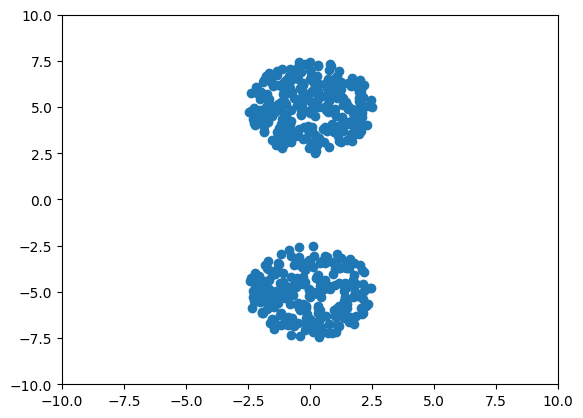

In [5]:
covariate_samples = np.load(os.getcwd() + "\\covariate_samples\\spherical_covariate_samples_2_500.npy")
coefficient_samples = np.load(os.getcwd() + "\\coefficient_samples\\spherical_coefficient_samples_2_500.npy")
dependent_samples = np.load(os.getcwd() + "\\dependent_samples\\spherical_dependent_samples_2_500.npy")
plt.plot(coefficient_samples[0,:], coefficient_samples[1,:], 'o')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()

0
10
20
30
40
50
60
70
80
90
5.764195442199707
0.6465474183760668


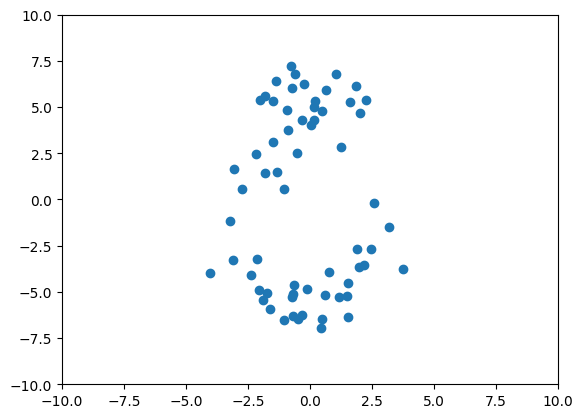

In [6]:
dimension = 2
radius = 10
sample_size = 500
N_particles = int(np.ceil(sample_size ** (dimension / (2 * dimension - 1))))
estimator = generative_model(dimension, radius, covariate_samples, dependent_samples)

algorithm_iteration = 100
estimation_array = np.zeros((estimator.dimension * algorithm_iteration, N_particles))
time_array = np.zeros(algorithm_iteration)
distance_array = np.zeros(algorithm_iteration)

iteration = 20
unit_sample_size = 50
step_size = 1
reg_parameter = 0.01

for iter in range(algorithm_iteration):
    if iter % 10 == 0:
        print(iter)
    time_start = time.time()
    estimation = estimator.generative_algorithm(iteration, unit_sample_size, N_particles, step_size, reg_parameter)
    time_end = time.time()
    duration = time_end - time_start
    
    estimation_array[estimator.dimension * iter : estimator.dimension * (iter + 1), : ] = estimation
    time_array[iter] = duration
    distance_array[iter] = ot.sliced.sliced_wasserstein_distance(estimation.T, coefficient_samples.T, n_projections= 100, p = 2)

np.save(os.getcwd() + "\\generative_samples_data\\generative_samples_spherical_2_500_01", estimation_array)
np.save(os.getcwd() + "\\generative_time_data\\generative_time_spherical_2_500_01", time_array)
np.save(os.getcwd() + "\\generative_distance_data\\generative_distance_spherical_2_500_01", distance_array)

print(time_array[-1])
print(distance_array[-1])
plt.plot(estimation_array[-2, :], estimation_array[-1, :], 'o')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()